##Predicting survival on the Titanic using logistic regression

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
pd.options.display.max_columns = 50
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/Users/shannon/Documents/CSC570/data/train.csv')

In [3]:
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


###Data transformation
* Drop PassengerId and Name
* Get dummies for Sex and Pclass
* Calculate mean by Sex and Parch to fill in nulls for Age
* Calculate ticket length
* Get first letter of ticket
* Drop Ticket, Cabin, and Embarked

In [5]:
X = pd.DataFrame(df)

In [6]:
#Drop passengerid and name
X = X.drop(['PassengerId', 'Name'], axis=1)

In [7]:
#Get dummies for sex
#Female = 1, Male = 0
X.Sex = pd.get_dummies(X.Sex)['female']

In [8]:
#Get dummies for Pclass
X = X.join(pd.get_dummies(X.Pclass, prefix='pclass'))

In [9]:
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_1,pclass_2,pclass_3
0,0,3,0,22,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,1,1,1,38,1,0,PC 17599,71.2833,C85,C,1,0,0
2,1,3,1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,1,1,1,35,1,0,113803,53.1000,C123,S,1,0,0
4,0,3,0,35,0,0,373450,8.0500,NaN,S,0,0,1


In [10]:
#Drop Pclass and pclass_3
X = X.drop(['Pclass', 'pclass_3'], axis=1)

In [11]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_1,pclass_2
0,0,0,22,1,0,A/5 21171,7.2500,NaN,S,0,0
1,1,1,38,1,0,PC 17599,71.2833,C85,C,1,0
2,1,1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,1,1,35,1,0,113803,53.1000,C123,S,1,0
4,0,0,35,0,0,373450,8.0500,NaN,S,0,0


In [12]:
X.Age.mean()

29.69911764705882

In [13]:
#Creating values for null ages
female_no_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 1) & (df.Parch == 0)].mean()
male_no_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 0) & (df.Parch == 0)].mean()
female_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 1) & (df.Parch > 0) ].mean()
male_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 0) & (df.Parch > 0) ].mean()

In [14]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 1) & (X.Parch == 0)] = female_no_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 0) & (X.Parch == 0)] = male_no_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 1) & (X.Parch > 0)] = female_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 0) & (X.Parch > 0)] = male_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
X[(X.Age.isnull() == True)]

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_1,pclass_2


In [19]:
X.Age.mean()

29.99899733306021

In [20]:
X[X.Fare.isnull() == True]

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_1,pclass_2


In [21]:
#Create column for ticket length
X['ticket_length'] = [len(df.Ticket.iloc[x]) for x in range(len(df.Ticket))]

In [22]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_1,pclass_2,ticket_length
0,0,0,22,1,0,A/5 21171,7.2500,NaN,S,0,0,9
1,1,1,38,1,0,PC 17599,71.2833,C85,C,1,0,8
2,1,1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,16
3,1,1,35,1,0,113803,53.1000,C123,S,1,0,6
4,0,0,35,0,0,373450,8.0500,NaN,S,0,0,6


In [23]:
#Create column for first letter of ticket
X['ticket_first'] = X['Ticket'].str[:1]

In [24]:
#Get dummies for first letter of ticket
X = X.join(pd.get_dummies(X.ticket_first, prefix='ticket_first'))

In [25]:
#Drop ticket
X = X.drop(['Ticket', 'ticket_first_S', 'ticket_first'], axis=1)

In [26]:
#Drop cabin
X = X.drop('Cabin', axis=1)

In [27]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,pclass_1,pclass_2,ticket_length,ticket_first_1,ticket_first_2,ticket_first_3,ticket_first_4,ticket_first_5,ticket_first_6,ticket_first_7,ticket_first_8,ticket_first_9,ticket_first_A,ticket_first_C,ticket_first_F,ticket_first_L,ticket_first_P,ticket_first_W
0,0,0,22,1,0,7.2500,S,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,38,1,0,71.2833,C,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1,26,0,0,7.9250,S,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,35,1,0,53.1000,S,1,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,35,0,0,8.0500,S,0,0,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
X = X.drop(['Embarked'], axis=1)

In [29]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Fare,pclass_1,pclass_2,ticket_length,ticket_first_1,ticket_first_2,ticket_first_3,ticket_first_4,ticket_first_5,ticket_first_6,ticket_first_7,ticket_first_8,ticket_first_9,ticket_first_A,ticket_first_C,ticket_first_F,ticket_first_L,ticket_first_P,ticket_first_W
0,0,0,22,1,0,7.2500,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,38,1,0,71.2833,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1,26,0,0,7.9250,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,35,1,0,53.1000,1,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,35,0,0,8.0500,0,0,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
#Setting dependent variable to y and dropping from X
y = X.Survived
X = X.drop('Survived', axis=1)

###Logistic Regression

In [31]:
#Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
model = LogisticRegression(penalty='l2', C=10)

In [33]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [34]:
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [35]:
#Borrow score code from class lecture notebook
print "Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test))

Logistic accuracy is 0.83


In [36]:
print "\n\n---Logistic Model---"
#logistic AUC
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print "Logistic AUC = %2.2f" % logit_roc_auc
print classification_report(y_test, model.predict(X_test) )



---Logistic Model---
Logistic AUC = 0.81
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       105
          1       0.83      0.73      0.78        74

avg / total       0.83      0.83      0.82       179



In [37]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

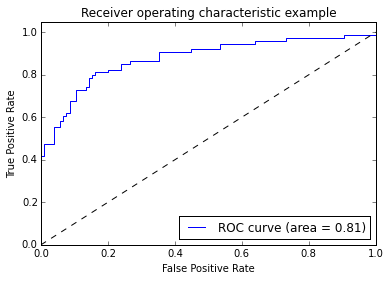

In [38]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###Scores
* L1, C1 = Accuracy 0.82, AUC 0.81
* L1, C10 = Accuracy 0.83, AUC 0.81
* L2, C1 = Accuracy 0.83, AUC 0.81
* L2, C10 = Accuracy 0.83, AUC 0.81

###Feature importance
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

In [40]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=42)

In [41]:
forest.fit(X_scaled, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
importances = forest.feature_importances_

In [43]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [44]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_scaled.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. Feature Sex (0.274375)
2. Feature Age (0.238958)
3. Feature SibSp (0.182090)
4. Feature Parch (0.049612)
5. Feature Fare (0.045810)
6. Feature pclass_1 (0.042823)
7. Feature pclass_2 (0.039313)
8. Feature ticket_length (0.025566)
9. Feature ticket_first_1 (0.024310)
10. Feature ticket_first_2 (0.021804)
11. Feature ticket_first_3 (0.012474)
12. Feature ticket_first_4 (0.009183)
13. Feature ticket_first_5 (0.006321)
14. Feature ticket_first_6 (0.006114)
15. Feature ticket_first_7 (0.005953)
16. Feature ticket_first_8 (0.005054)
17. Feature ticket_first_9 (0.004486)
18. Feature ticket_first_A (0.001726)
19. Feature ticket_first_C (0.001512)
20. Feature ticket_first_F (0.000942)
21. Feature ticket_first_L (0.000743)
22. Feature ticket_first_P (0.000541)
23. Feature ticket_first_W (0.000292)


####Other version I tried with more features had a logistic accuracy score of 0.81 and an AUC of .80 - embarked and cabin we bringing down the score a bit
Feature ranking:
1. Feature Sex (0.264857)
2. Feature Age (0.222124)
3. Feature SibSp (0.166348)
4. Feature Parch (0.046965)
5. Feature Fare (0.044394)
6. Feature pclass_1 (0.044195)
7. Feature pclass_2 (0.042329)
8. Feature ticket_length (0.031464)
9. Feature ticket_first_1 (0.026675)
10. Feature ticket_first_2 (0.022301)
11. Feature ticket_first_3 (0.018798)
12. Feature ticket_first_4 (0.015935)
13. Feature ticket_first_5 (0.012867)
14. Feature ticket_first_6 (0.007621)
15. Feature ticket_first_7 (0.006148)
16. Feature ticket_first_8 (0.006037)
17. Feature ticket_first_9 (0.005056)
18. Feature ticket_first_A (0.003846)
19. Feature ticket_first_C (0.003798)
20. Feature ticket_first_F (0.002649)
21. Feature ticket_first_L (0.001969)
22. Feature ticket_first_P (0.001749)
23. Feature ticket_first_S (0.000747)
24. Feature cabin_not_null (0.000516)
25. Feature embarked_Q (0.000450)
26. Feature embarked_S (0.000163)
